In [11]:
!pip install pandas==1.3.5
!pip install missingno

  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [1]:
import io
import boto3
import configparser

import numpy as np
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# Load s3 file

In [2]:
def get_credential_info(section_name):
    
    parser = configparser.ConfigParser()
    parser.read('./config.ini')
    access_key = parser.get(section_name, "access_key")
    secret_key = parser.get(section_name, "secret_key")
    
    return access_key, secret_key

def get_s3_file_list(section_name, bucket_name, prefix):
    
    access_key, secret_key = get_credential_info(section_name)
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key,
                      aws_secret_access_key=secret_key)

    contents = s3.list_objects(Bucket=bucket_name,
                               Prefix=prefix)["Contents"]
    
    return contents

def get_s3_file(section_name, bucket_name, file):
    
    access_key, secret_key = get_credential_info(section_name)
    
    s3 = boto3.client('s3',
                      aws_access_key_id=access_key,
                      aws_secret_access_key=secret_key)
    
    obj = s3.get_object(Bucket=bucket_name, Key=file)
    
    print("Read "+file, end=" -> ")
    df = pd.read_csv( io.BytesIO( obj["Body"].read() ) ) 
    print("Completed")
    print("Data size:", df.shape, end="\n")
    
    return df

In [3]:
section_name = "aws_boto_credentials"
bucket_name = "ev-depreciation-model"

In [4]:
files = get_s3_file_list(section_name, bucket_name, "raw")

df = pd.DataFrame()
for file in files:
    
    key = file["Key"]
    
    if key[4:] in ["", "vehicles.csv"]:
        continue
    else:
        df_temp = get_s3_file(section_name, bucket_name, key)
        df_temp["manufacturer"] = [key[4:-4]]*len(df_temp)
        df = pd.concat([df, df_temp], axis=0)

print(df.shape)

Read raw/audi.csv -> Completed
Data size: (10668, 9)
Read raw/bmw.csv -> Completed
Data size: (10781, 9)
Read raw/cclass.csv -> Completed
Data size: (3899, 7)
Read raw/focus.csv -> Completed
Data size: (5454, 7)
Read raw/ford.csv -> Completed
Data size: (17965, 9)
Read raw/hyundi.csv -> Completed
Data size: (4860, 9)
Read raw/merc.csv -> Completed
Data size: (13119, 9)
Read raw/skoda.csv -> Completed
Data size: (6267, 9)
Read raw/toyota.csv -> Completed
Data size: (6738, 9)
Read raw/vauxhall.csv -> Completed
Data size: (13632, 9)
Read raw/vw.csv -> Completed
Data size: (15157, 9)
(108540, 11)


# EDA - used cars

## 1. Structure

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108540 entries, 0 to 15156
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   model         108540 non-null  object 
 1   year          108540 non-null  int64  
 2   price         108540 non-null  int64  
 3   transmission  108540 non-null  object 
 4   mileage       108540 non-null  int64  
 5   fuelType      108540 non-null  object 
 6   tax           94327 non-null   float64
 7   mpg           99187 non-null   float64
 8   engineSize    108540 non-null  float64
 9   manufacturer  108540 non-null  object 
 10  tax(£)        4860 non-null    float64
dtypes: float64(4), int64(3), object(4)
memory usage: 9.9+ MB


### 1.1. Structure of non-numerical features

In [6]:
df.describe(exclude="number")

,model,transmission,fuelType,manufacturer
count,108540,108540,108540,108540
unique,195,4,5,11
top,Focus,Manual,Petrol,ford
freq,10042,61308,59875,17965


In [7]:
# uqnique count is less than 15 
cols_few_category = df.columns[df.nunique()<=15]

for col in cols_few_category:
    print(f"[{col}]")
    print(df[col].value_counts(dropna=False))
    print("====================")

[transmission]
Manual       61308
Semi-Auto    24903
Automatic    22319
Other           10
Name: transmission, dtype: int64
[fuelType]
Petrol      59875
Diesel      45177
Hybrid       3229
Other         253
Electric        6
Name: fuelType, dtype: int64
[manufacturer]
ford        17965
vw          15157
vauxhall    13632
merc        13119
bmw         10781
audi        10668
toyota       6738
skoda        6267
focus        5454
hyundi       4860
cclass       3899
Name: manufacturer, dtype: int64


In [8]:
# uqnique ratio is less than 15 
cols_few_category = df.columns[df.nunique()<=15]

for col in cols_few_category:
    print(f"[{col}]")
    print(df[col].value_counts(dropna=False, normalize=True)*100)
    print("====================")

[transmission]
Manual       56.484245
Semi-Auto    22.943615
Automatic    20.562926
Other         0.009213
Name: transmission, dtype: float64
[fuelType]
Petrol      55.163995
Diesel      41.622443
Hybrid       2.974940
Other        0.233094
Electric     0.005528
Name: fuelType, dtype: float64
[manufacturer]
ford        16.551502
vw          13.964437
vauxhall    12.559425
merc        12.086788
bmw          9.932744
audi         9.828635
toyota       6.207850
skoda        5.773908
focus        5.024876
hyundi       4.477612
cclass       3.592224
Name: manufacturer, dtype: float64


### 1.2. Structure of numerical features

Range of numeric features
* year : 1970 ~ 2060
* price : 450 ~ 159,999
* milege : 1 ~ 323,000
* tax : 0 ~ 580
* mpg : 0.3 ~ 470.8
* engineSize : 0 ~ 6.6
* tax : 0 ~ 555

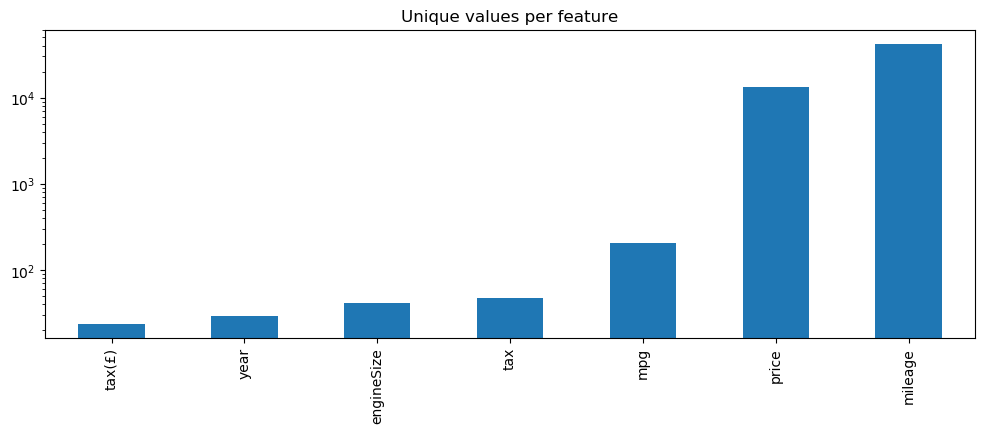

In [9]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(12,4), title="Unique values per feature")
plt.show()

In [10]:
df.select_dtypes(include="number").describe()

,year,price,mileage,tax,mpg,engineSize,tax(£)
count,108540.000000,108540.000000,108540.000000,94327.000000,99187.000000,108540.000000,4860.000000
mean,2017.098028,16890.124046,23025.928469,120.256183,55.166825,1.661644,121.147119
std,2.130057,9756.266820,21176.423684,63.404805,16.138522,0.557058,58.003289
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000,125.000000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000,145.000000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000,145.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000,555.000000


## 2. Quality

### 2.1. Missing values

#### 2.1.1. Per sample

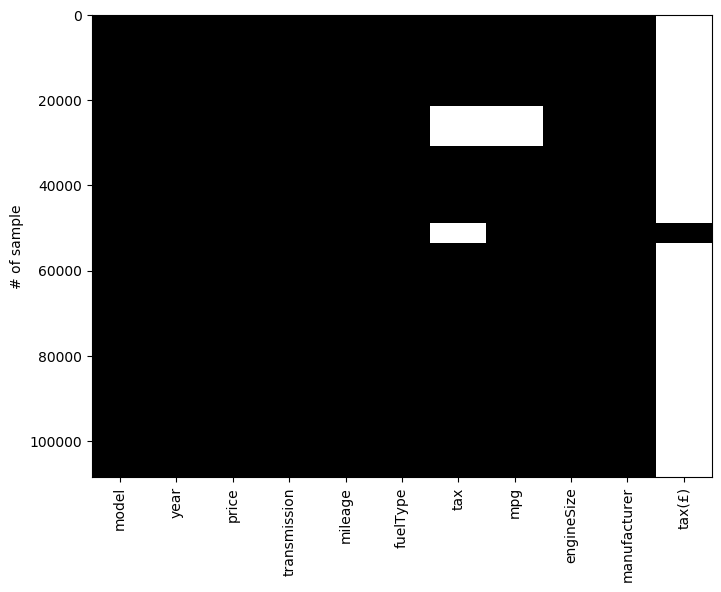

In [12]:
plt.figure(figsize=(8, 6))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.ylabel("# of sample")
plt.xticks(np.arange(df.shape[1]), labels=df.columns, rotation=90)
plt.show()

#### 2.1.2. Per Feature

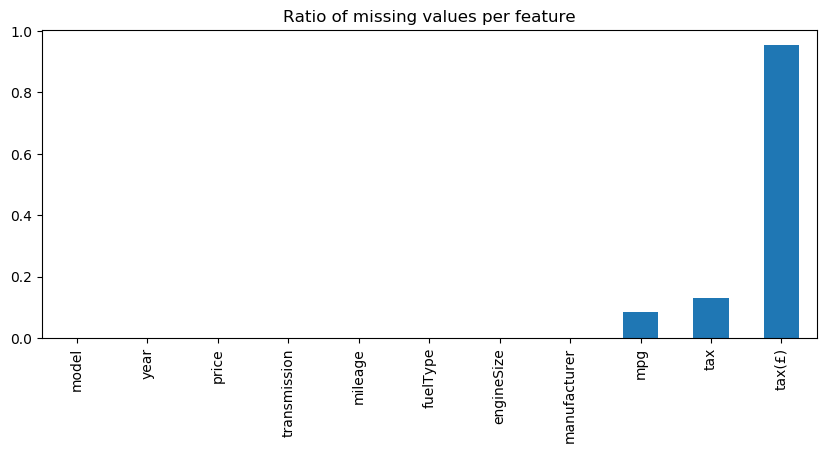

In [13]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(10,4),
    title="Ratio of missing values per feature",
)
plt.show()

### 2.2. Outliers

#### 2.2.1. Numerical features 

No handles with labels found to put in legend.


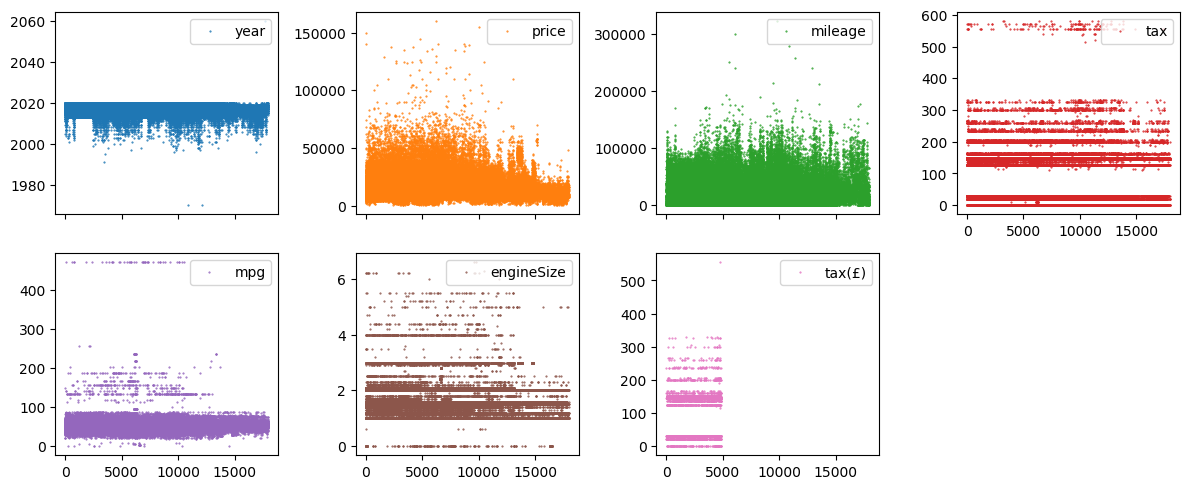

In [34]:
# df.plot(subplots=True) - to plot each feature in a separate subplot
df.plot(lw=0, marker=".", subplots=True, 
        layout=(-1,4), figsize=(12, 5), markersize=1)
for ax in plt.gcf().axes:
    ax.legend(loc=1)
plt.tight_layout()
plt.show()

#### 2.2.2. Non-numerical features

In [18]:
set(df.select_dtypes(exclude=["number"]).columns)

{'fuelType', 'manufacturer', 'model', 'transmission'}

In [19]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'manufacturer', 'tax(£)'],
      dtype='object')

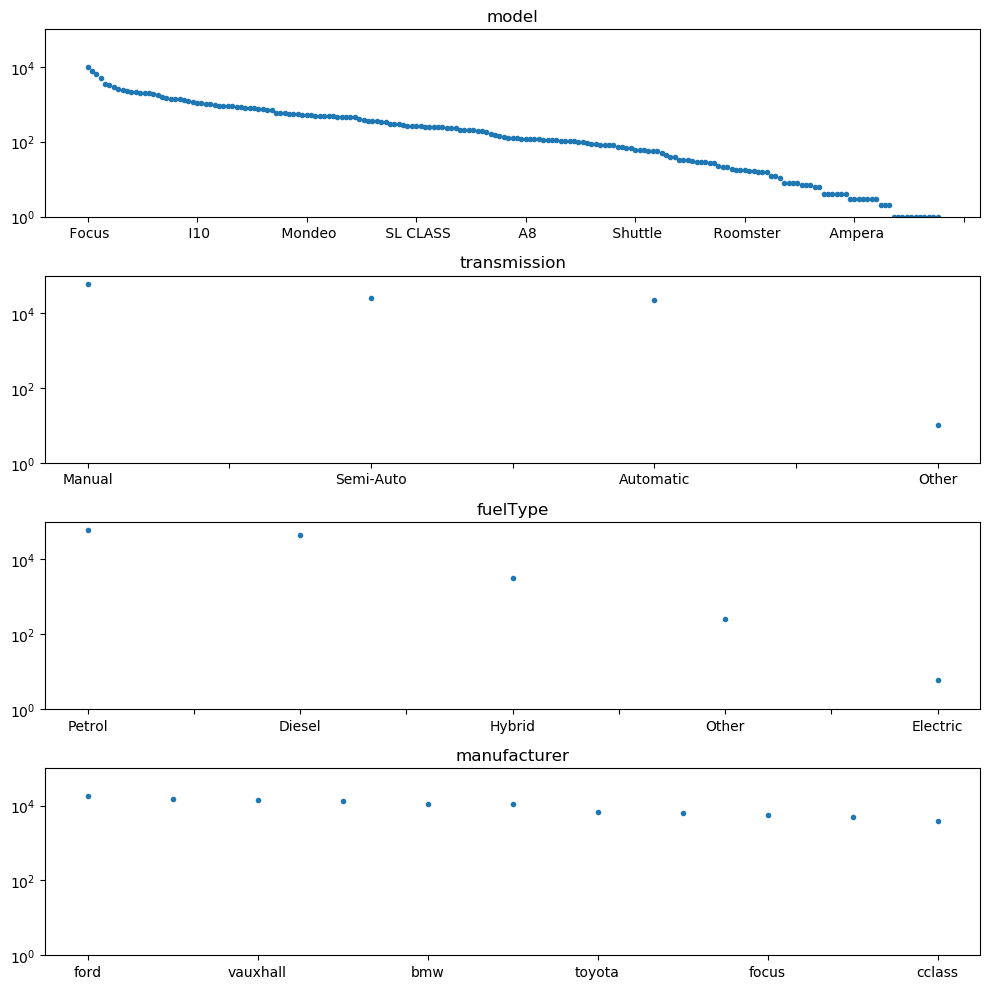

In [23]:
cols_non_numerical = set(df.select_dtypes(exclude=["number"]).columns)
nrows = len(cols_non_numerical)

# value ratio of each feature
fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(10, 2.5*nrows))

for col, ax in zip(cols_non_numerical, axs.ravel()):    
    df[col].value_counts(dropna=False).plot(
        logy=True, title=col, lw=0, marker=".", ax=ax
    )
    ax.set_ylim(1, 1e5)
plt.tight_layout()
plt.show()

In [24]:
display(df["model"].value_counts().sort_index()[:20])
display(df["model"].value_counts().sort_index()[-20:])

 1 Series    1969
 2 Series    1229
 3 Series    2443
 4 Series     995
 5 Series    1056
 6 Series     108
 7 Series     106
 8 Series      39
 A Class     2561
 A1          1347
 A2             1
 A3          1929
 A4          1381
 A5           882
 A6           748
 A7           122
 A8           118
 Accent         1
 Adam         463
 Agila         22
Name: model, dtype: int64

 X1                804
 X2                288
 X3                551
 X4                179
 X5                468
 X6                106
 X7                 55
 Yaris            2122
 Yeti              136
 Yeti Outdoor      458
 Z3                  7
 Z4                108
 Zafira            599
 Zafira Tourer      58
 i3                 43
 i8                 17
180                  1
200                  1
220                  1
230                  1
Name: model, dtype: int64

## 3. Content

### 3.1. Feature patterns

#### 3.1.1. Continuous features

In [25]:
cols_continuous = df.select_dtypes(include="number").nunique() > 25
cols_continuous

year           True
price          True
mileage        True
tax            True
mpg            True
engineSize     True
tax(£)        False
dtype: bool

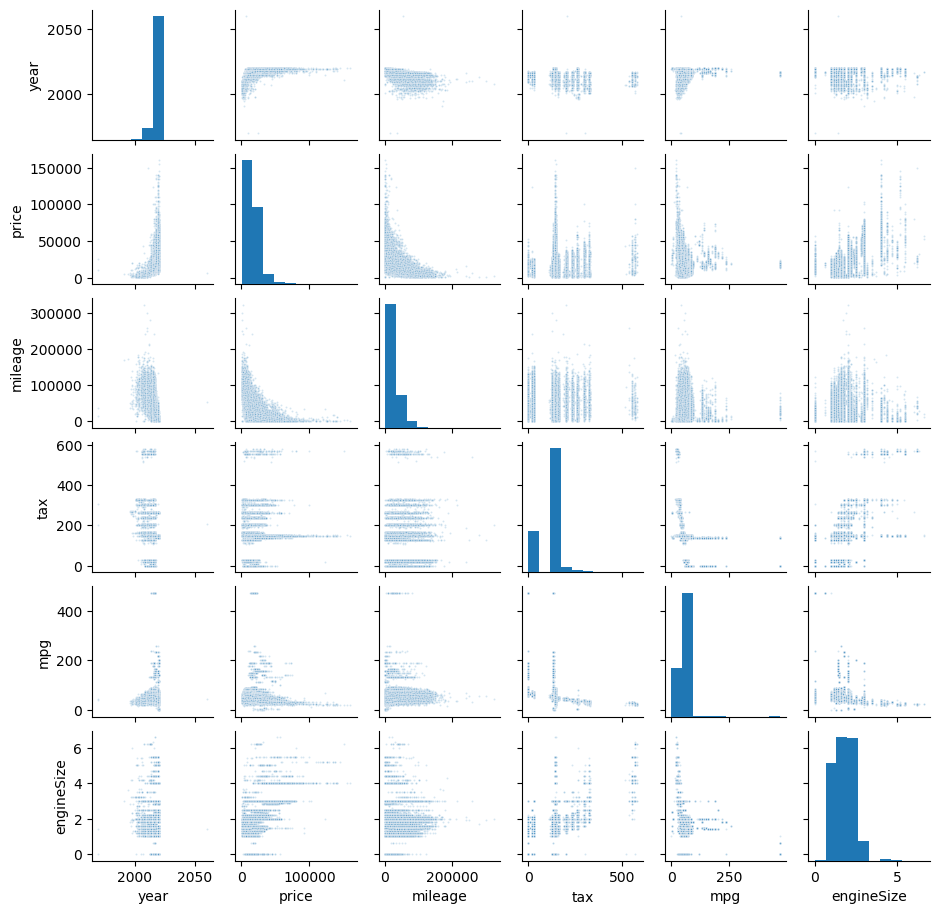

In [27]:
df_continuous = df[cols_continuous[cols_continuous==True].index]

sns.pairplot(df_continuous, height=1.5, plot_kws={"s":2, "alpha":0.2})
plt.show()

#### 3.1.2. Discrete features

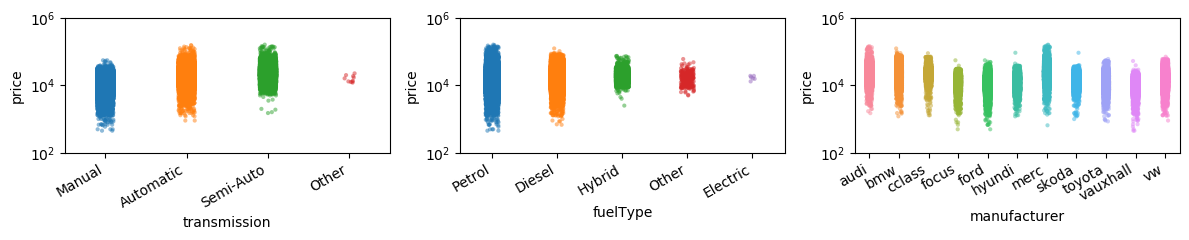

In [30]:
cols_discrete = df.select_dtypes(exclude="number").nunique() < 25
col_x = cols_discrete[cols_discrete].index

col_y = "price"

n_cols = 3
n_elements = len(col_x)
n_rows = np.ceil(n_elements / n_cols).astype("int")

fig, axs = plt.subplots(
    ncols=n_cols, nrows=n_rows, figsize=(12, n_rows*2.5)
)

for col, ax in zip(col_x, axs.ravel()):
    sns.stripplot(
        data=df, x=col, y=col_y, ax=ax, size=3, alpha=0.5
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_yscale("log")
    ax.set_ylim(1e2, 1e6)

plt.tight_layout()
plt.show()

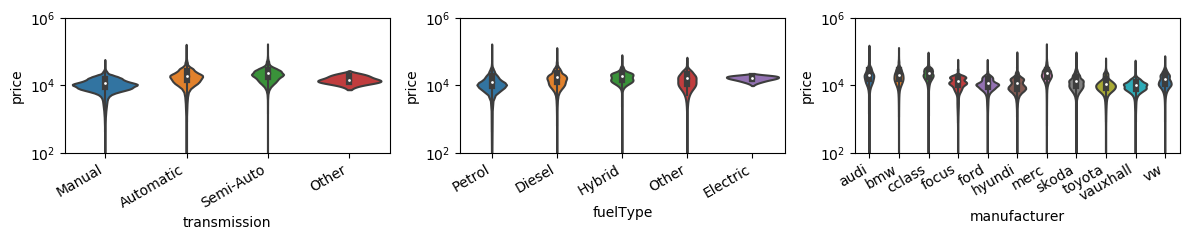

In [32]:
cols_discrete = df.select_dtypes(exclude="number").nunique() < 25
col_x = cols_discrete[cols_discrete].index

col_y = "price"

n_cols = 3
n_elements = len(col_x)
n_rows = np.ceil(n_elements / n_cols).astype("int")

fig, axs = plt.subplots(
    ncols=n_cols, nrows=n_rows, figsize=(12, n_rows*2.5)
)

for col, ax in zip(col_x, axs.ravel()):
    sns.violinplot(
        data=df, x=col, y=col_y, ax=ax, palette="tab10"
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_yscale("log")
    ax.set_ylim(1e2, 1e6)

plt.tight_layout()
plt.show()

### 3.2. Feature relationships

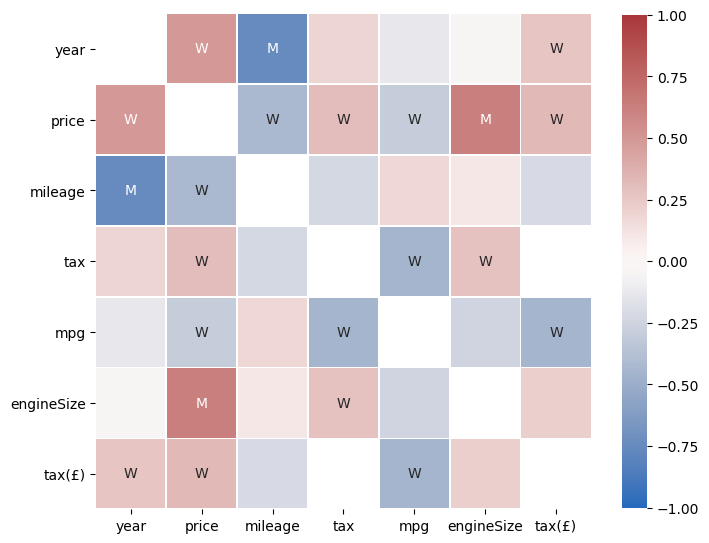

In [33]:
df_corr = df.corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75, "S", 
                 np.where(np.abs(df_corr)>0.5, "M",
                         np.where(np.abs(df_corr)>0.25, "W", "")))

plt.figure(figsize=(8,8))
sns.heatmap(
    df_corr, mask=np.eye(len(df_corr)), 
    square=True, center=0, 
    annot=labels, fmt="", 
    linewidths=.5, cmap="vlag", 
    cbar_kws={"shrink":0.8}, vmin=-1, vmax=1
)
plt.show()